## Lab 8.01 Neural Network Binary Classification
_By Jeff Hale_

This lab uses a small [dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) provided by the Cleveland Clinic Foundation for Heart Disease. The goal is to predict whether a patient has heart disease (the *target* column).

We suggest running this lab in [Google Colab](https://colab.research.google.com/). 

Go *File*->*Upload notebook* to upload this notebook to colab.

If you are working in Colab and want to see if you can get a speed boost, set your runtime to *TPU* by going to *Runtime*->*Change runtime type* in the menu above. 

The processor type won't make a big difference with this small dataset and small networks, but it's good to know how to change the processor.

### Read data and load using pandas

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [2]:
from google.colab import files
uploaded = files.upload()

Saving heart.csv to heart.csv


#### Load the csv file using pandas.

In [5]:
data = pd.read_csv('heart.csv')

#### Inspect

In [6]:
data.sample(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
56,48,1,0,122,222,0,0,186,0,0.0,2,0,2,1
245,48,1,0,124,274,0,0,166,0,0.5,1,0,3,0
66,51,1,2,100,222,0,1,143,1,1.2,1,0,2,1
57,45,1,0,115,260,0,0,185,0,0.0,2,0,2,1
244,56,1,0,132,184,0,0,105,1,2.1,1,1,1,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


#### Check the value counts of the column that's an object

In [12]:
data.dtypes
# there is no column that is an object.

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

You could load data into a format for TensorFlow using `tf.data.Dataset`, but these are unwieldly - it's a serious pain to create a validation dataset from a TF dataset. You used to have to make your data into NumPy arrays for TensorFlow. Now you can just keep them as pandas DataFrames!

#### Set up X and y

In [14]:
X = data.drop('target', axis=1)
y = data['target']

#### Train-test split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, stratify=y)

In [25]:
X_train

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
279,61,1,0,138,166,0,0,125,1,3.6,1,1,2
264,54,1,0,110,206,0,0,108,1,0.0,1,1,2
293,67,1,2,152,212,0,0,150,0,0.8,1,0,3
219,48,1,0,130,256,1,0,150,1,0.0,2,2,3
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,43,0,0,132,341,1,0,136,1,3.0,1,0,3
230,47,1,2,108,243,0,1,152,0,0.0,2,0,2
135,49,0,0,130,269,0,1,163,0,0.0,2,0,2
70,54,1,2,120,258,0,0,147,0,0.4,1,0,3


Convert `thal` column to numeric

### Let's use a friendlier OHE! 🎉

In [16]:
!pip install category_encoders 
import category_encoders as ce

     |████████████████████████████████| 81kB 3.5MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [19]:
ohe = ce.OneHotEncoder()
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


#### Set the TensorFlow random seed

In [22]:
tf.random.set_seed(3)

## Create and train a model

#### Create model structure

In [27]:
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(13,)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

#### Visualize the structure

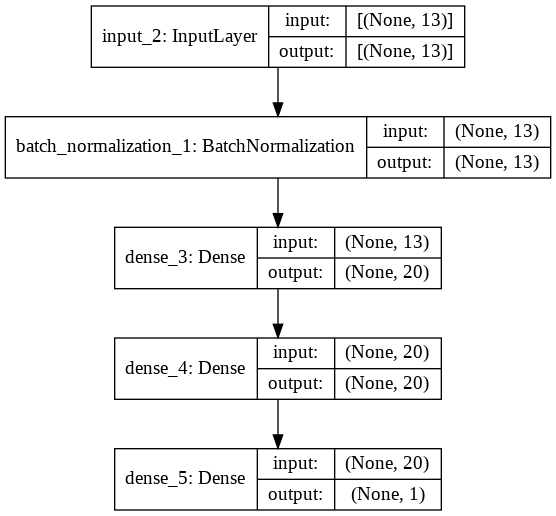

In [28]:
tf.keras.utils.plot_model(model,show_shapes=True)

#### Compile

In [29]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy', 'Recall', 'Precision'],
  )

#### Make an EarlyStopping callback

In [30]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#### Fit the model

In [49]:
history = model.fit(X_train, y_train, batch_size=10, epochs=50, validation_split=0.3, callbacks=[callback])  

Epoch 1/50
16/16 [==============================] - 0s 11ms/step - loss: 0.3485 - accuracy: 0.8354 - recall: 0.8837 - precision: 0.8261 - val_loss: 0.3749 - val_accuracy: 0.8841 - val_recall: 0.8947 - val_precision: 0.8947
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.2928 - accuracy: 0.8797 - recall: 0.9070 - precision: 0.8764 - val_loss: 0.3732 - val_accuracy: 0.8696 - val_recall: 0.8947 - val_precision: 0.8718
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.2852 - accuracy: 0.8861 - recall: 0.9419 - precision: 0.8617 - val_loss: 0.3743 - val_accuracy: 0.8696 - val_recall: 0.8947 - val_precision: 0.8718
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.2801 - accuracy: 0.9051 - recall: 0.9186 - precision: 0.9080 - val_loss: 0.3779 - val_accuracy: 0.8551 - val_recall: 0.8684 - val_precision: 0.8684
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.3325 - accuracy: 0.8418 - recall: 0.8

#### Plot model performance on the validation data (accuracy, recall, and precision)

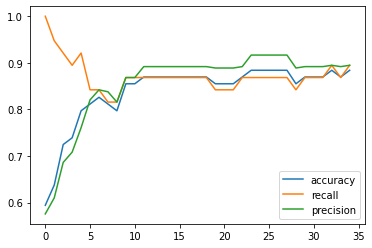

In [33]:
plt.plot(history.history['val_accuracy'], label='accuracy')
plt.plot(history.history['val_recall'], label='recall')
plt.plot(history.history['val_precision'], label='precision')
plt.legend();

#### Save model

In [34]:
model.save('model_1')

INFO:tensorflow:Assets written to: model_1/assets


#### Load model

In [35]:
model_reload = tf.keras.models.load_model('model_1')

#### Evaluate on test set 

In [36]:
model_reload.evaluate(X_test, y_test) 

3/3 [==============================] - 0s 4ms/step - loss: 0.3871 - accuracy: 0.8158 - recall: 0.9024 - precision: 0.7872


[0.38708817958831787,
 0.8157894611358643,
 0.9024389982223511,
 0.7872340679168701]

#### X_test predictions

In [37]:
preds = model_reload.predict(X_test)

#### What do those look like?

In [39]:
preds.round()

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.]], dtype=float

#### How is the model performing? 
Let's look at the confusion matrix using TF.

In [40]:
tf.math.confusion_matrix(labels=y_test, predictions=preds.round())

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[25, 10],
       [ 4, 37]], dtype=int32)>

Or just use sklearn's confusion matrix. 

In [41]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, preds.round())

array([[25, 10],
       [ 4, 37]])

#### Evaluate with other metrics

In [42]:
from sklearn.metrics import recall_score, precision_score, f1_score, balanced_accuracy_score

In [43]:
recall_score(y_test, preds.round())

0.9024390243902439

In [44]:
f1_score(y_test, preds.round())

0.8409090909090909

In [45]:
balanced_accuracy_score(y_test, preds.round())

0.8083623693379791

### Make a null model

In [48]:
data['target'].value_counts(normalize=True)
# the null model is to classify each observation as 1, then 54.45% will be right.

1    0.544554
0    0.455446
Name: target, dtype: float64

## Can you make a better model?

Change the model architecture and see if you can make a better model. Add nodes, dense layers, and dropout layers.

In [50]:
# model2
model2 = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(13,)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy', 'Recall', 'Precision'],
  )

history2 = model2.fit(X_train, y_train, batch_size=10, epochs=50, validation_split=0.3, callbacks=[callback])  

Epoch 1/50
16/16 [==============================] - 2s 38ms/step - loss: 0.6663 - accuracy: 0.5498 - recall: 1.0000 - precision: 0.5460 - val_loss: 4.1008 - val_accuracy: 0.5507 - val_recall: 1.0000 - val_precision: 0.5507
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.6493 - accuracy: 0.5553 - recall: 1.0000 - precision: 0.5508 - val_loss: 2.6992 - val_accuracy: 0.5507 - val_recall: 1.0000 - val_precision: 0.5507
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.6806 - accuracy: 0.5524 - recall: 1.0000 - precision: 0.5380 - val_loss: 1.9854 - val_accuracy: 0.5507 - val_recall: 1.0000 - val_precision: 0.5507
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.6537 - accuracy: 0.5784 - recall: 0.9954 - precision: 0.5541 - val_loss: 1.5430 - val_accuracy: 0.5507 - val_recall: 1.0000 - val_precision: 0.5507
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.5959 - accuracy: 0.6754 - recall: 0.9

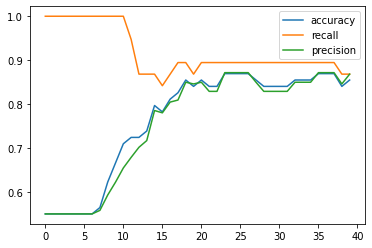

In [51]:
plt.plot(history2.history['val_accuracy'], label='accuracy')
plt.plot(history2.history['val_recall'], label='recall')
plt.plot(history2.history['val_precision'], label='precision')
plt.legend();

In [52]:
preds2 = model2.predict(X_test)

In [53]:
recall_score(y_test, preds2.round())

0.8292682926829268

In [55]:
f1_score(y_test, preds2.round())

0.8095238095238095

In [56]:
balanced_accuracy_score(y_test, preds.round())

0.8083623693379791

#### Save your best model. 


In [57]:
# first first model is the best

#### Compare with other algorithms
Compare your best neural net model to a scikit-learn LogisticRegression model. Also try a GradientBoostingClassifier.

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

#### Scale and Standardize for Logistic Regression


In [59]:
from sklearn.preprocessing import StandardScaler

In [60]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

#### Logistic Regression

In [62]:
logreg = LogisticRegression()
logreg.fit(X_train_sc, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Evaluate performance on metrics other than accuracy

In [64]:
preds_logreg = logreg.predict(X_test_sc)

precision_score(y_test, preds_logreg)

0.7608695652173914

In [65]:
f1_score(y_test, preds_logreg)

0.8045977011494252

### GradientBoosting

In [66]:
from sklearn.model_selection import GridSearchCV

In [67]:
parames = dict(
    max_depth=[2,3,4,5], 
    n_estimators=[100, 300,700,1000]
    )
gs = GridSearchCV(GradientBoostingClassifier(), param_grid=parames, n_jobs=-1)
gs.fit(X_train, y_train)
gs.score(X_test, y_test)

0.7763157894736842

#### Evaluate performance on metrics other than accuracy

In [68]:
preds_gs = gs.predict(X_test)

precision_score(y_test, preds_gs)

0.7727272727272727

In [69]:
f1_score(y_test, preds_gs)

0.7999999999999999

#### Which evaluation metric(s) are best to use in this problem?

The combination of multiple metrics are the best.

#### Which model would you recommend for use? Why?

If interpretation is not necessary I would choose NN classification because it perfomances better than others. But Logistic Regression can be easily interpreted.


#### Download your notebook and put it in your submission folder. 🎉